In [1]:
import numpy as np
import pandas as pd
import random
import math
import copy
import ray
import geoz
import shap
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from sklearn.inspection import DecisionBoundaryDisplay
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, SVR
import matplotlib.pyplot as plt
from sklearn import metrics
from pyproj import CRS
from pyproj import Transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def bazel_cluster(X,y,n_samples=False, extent=1, random_seed=None):
    '''
    This Function Creates a Bazel round the study area, the defaults are robust but not gurateed to work.
    its pretty easy to check if the function worked or not by looking at the final map/Decision Boundary plot,
    if the map have a Bazel, it means the method didn't work and the user needs to adjust the default values to increase
    generated data points to force the model to consider the Bazel cluster as the background. if it works, the map will be
    clear, showing only the clusters of interest without the Bazel showing.
    
    Caution: This method have very specific usage to complement ONLY the SVM Classification algorithm by allowing all the 
    clusters to show on the Map through forcing the SVM Classifier to consider the generated dummy data as the majority, 
    thus acting as a background to the Decision Boundary plot which is a representation of the geographic map.
    
    X: Dataset containing only Longitude and Latitude (must be the only features used by the Classifier to create the final map).
    
    y: array or array-like containing only the predicted clusters names (Must be Numerical e.g. 1,2,3,4...).
    
    n_samples: this variable is generated based on your dataset, you only need to modify it if the method fails force 
    SVM Classifier to consider the cluster as a background.
    
    extent: the "width" of the generated Bazel, there should be no need to change this variable, however, if the method
    failed after menipulating n_samples, you could try to increase the default to 3 or 4 while increase the n_samples
    accourdingly.
    
    '''
    
    # latExtra= (latlong.LATITUDE.max()-latlong.LATITUDE.min())*0.5
    # longExtra= (latlong.LONGITUDE.max()-latlong.LONGITUDE.min())*0.5
    
    random.seed(a=random_seed)
    
    latExtra= X.LATITUDE.std()*extent
    longExtra= X.LONGITUDE.std()*extent
    
    LlatMin= X.LATITUDE.min()-X.LATITUDE.std()
    LlatMax= X.LATITUDE.max()+X.LATITUDE.std()
    LlongMin= X.LONGITUDE.min()-X.LONGITUDE.std()
    LlongMax= X.LONGITUDE.max()+X.LONGITUDE.std()
    
    UlatMin= X.LATITUDE.min()-latExtra
    UlatMax= X.LATITUDE.max()+latExtra
    UlongMin= X.LONGITUDE.min()-longExtra
    UlongMax= X.LONGITUDE.max()+longExtra
    
    bottom=[[LlatMin,UlatMin],(UlongMin,UlongMax)]
    top=[[LlatMax,UlatMax],(UlongMin,UlongMax)]
    left=[[UlatMin,UlatMax],(UlongMin,LlongMin)]
    right=[[LlatMin,UlatMax],(LlongMax,UlongMax)]
    sides=[bottom, top, left, right]
    lat=[]
    long=[]
    
    if n_samples==False:
        n_samples=pd.Series(y).value_counts().values[0]
    
    for side in sides:
        for i in range(math.ceil(n_samples/4)):
            pointLat=random.uniform(side[0][0],side[0][1])
            pointLong=random.uniform(side[1][0],side[1][1])
            lat.append(pointLat)
            long.append(pointLong)
    dataset=pd.DataFrame({'LONGITUDE': long,'LATITUDE': lat})
    dataset['y']=np.array(y).max()+1
    Y=copy.deepcopy(y)
    Y.extend(dataset['y'].values)
    dataset=dataset[['LONGITUDE','LATITUDE']]
    X=pd.concat((X, dataset), axis=0,ignore_index= True)
    return X,Y


In [3]:
data=pd.read_csv('SDG/MLPre.csv').set_index('Sample_Name')
data.rename(columns={'E':'LONGITUDE','N':'LATITUDE'},inplace=True)

latlong=data[['LATITUDE','LONGITUDE']]

data2= copy.deepcopy(data)
data2.drop(columns=['LONGITUDE','LATITUDE', 'SRTM_DEM (Elevation m)'], inplace=True)

scaler= StandardScaler()
data2S=pd.DataFrame(scaler.fit_transform(data2), index=data2.index, columns=data2.columns)

In [4]:
crs_latlong = CRS("EPSG:4326")            #WGS84 (Geographic Latitude & Longitude)
crs_proj = CRS('EPSG:32640')              #UTM (Projection UTM Zone 39/40)

transformer = Transformer.from_crs(crs_proj, crs_latlong)

latitudes, longitudes=transformer.transform(latlong['LONGITUDE'], latlong['LATITUDE'])
latlong.loc[:,'LONGITUDE'] = longitudes
latlong.loc[:,'LATITUDE']  = latitudes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
#Imputation Process

clf=RandomForestRegressor(n_estimators=200, max_depth=6,n_jobs=40, random_state=0)
CLimputer= IterativeImputer(estimator= clf)
SOimputer= KNNImputer(n_neighbors=10, weights='distance')

data2S.loc['R-KH18','Cl-']=pd.DataFrame(CLimputer.fit_transform(data2S), index=data2.index, columns=data2.columns).loc['R-KH18','Cl-']
data2S.loc['R-KH18','SO42+']=pd.DataFrame(SOimputer.fit_transform(data2S), index=data2.index, columns=data2.columns).loc['R-KH18','SO42+']
data_fill = copy.deepcopy(data2S)
data_filled=data_fill.drop('Temperature (C)', axis=1)

In [ ]:
data_filled.to_csv('datascaled.csv')

,Silhouette Score
Number of Clusters,
2,0.541393
5,0.34245
4,0.317031
3,0.310036
6,0.306645
8,0.281958
15,0.281552
9,0.275918
14,0.27511


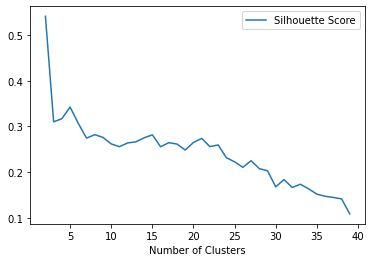

In [6]:
clusts=list(range(2,40))
clustNumb=pd.DataFrame(columns=['Number of Clusters','Silhouette Score'])
for cvi in clusts:
    clf = KMeans(n_clusters=cvi)
    clf.fit(data_filled)
    y_pred=list(clf.labels_)
    tempSill=pd.DataFrame({'Number of Clusters':[cvi],'Silhouette Score': [metrics.silhouette_score(data_filled, y_pred)]})
    clustNumb=pd.concat((clustNumb, tempSill), axis=0)
clustNumb['Number of Clusters'] = clustNumb['Number of Clusters'].astype(int)
clustNumb.set_index('Number of Clusters', inplace= True)
clustNumb.plot(y='Silhouette Score')
topclusts=list(clustNumb.sort_values(by='Silhouette Score', ascending=False).index[0:4])
clustNumb.sort_values(by='Silhouette Score', ascending=False)
#Number of Clusters Determination
# ClustPlot = clustNumb.plot(y='Silhouette Score', label = 'K-Means')

In [154]:
clustNumb.sort_values(by='Silhouette Score', ascending=False).to_csv('SillScore.csv')
temp=clustNumb.plot(y='Silhouette Score',figsize=(15,10))
temp.figure.savefig('SillCore.png')

In [138]:
#StudyAREA Shapefile
shpath = "StudyArea.shp" #Shapefile Path
shapFile = gpd.read_file(shpath)
shapFileFiltered=shapFile.to_crs("EPSG:4326")                    #Polygon

gdf = gpd.GeoDataFrame(latlong, geometry=gpd.points_from_xy(latlong.LONGITUDE, latlong.LATITUDE,crs="EPSG:4326"))  #Points

Number of Clusters:  2
X:  45
y:  45
X2:  81
y2:  81
Drawing Accuracy:  1.0 


Number of Clusters:  5
X:  45
y:  45
X2:  65
y2:  65
Drawing Accuracy:  1.0 


Number of Clusters:  4
X:  45
y:  45
X2:  65
y2:  65
Drawing Accuracy:  1.0 


Number of Clusters:  3
X:  45
y:  45
X2:  65
y2:  65
Drawing Accuracy:  1.0 




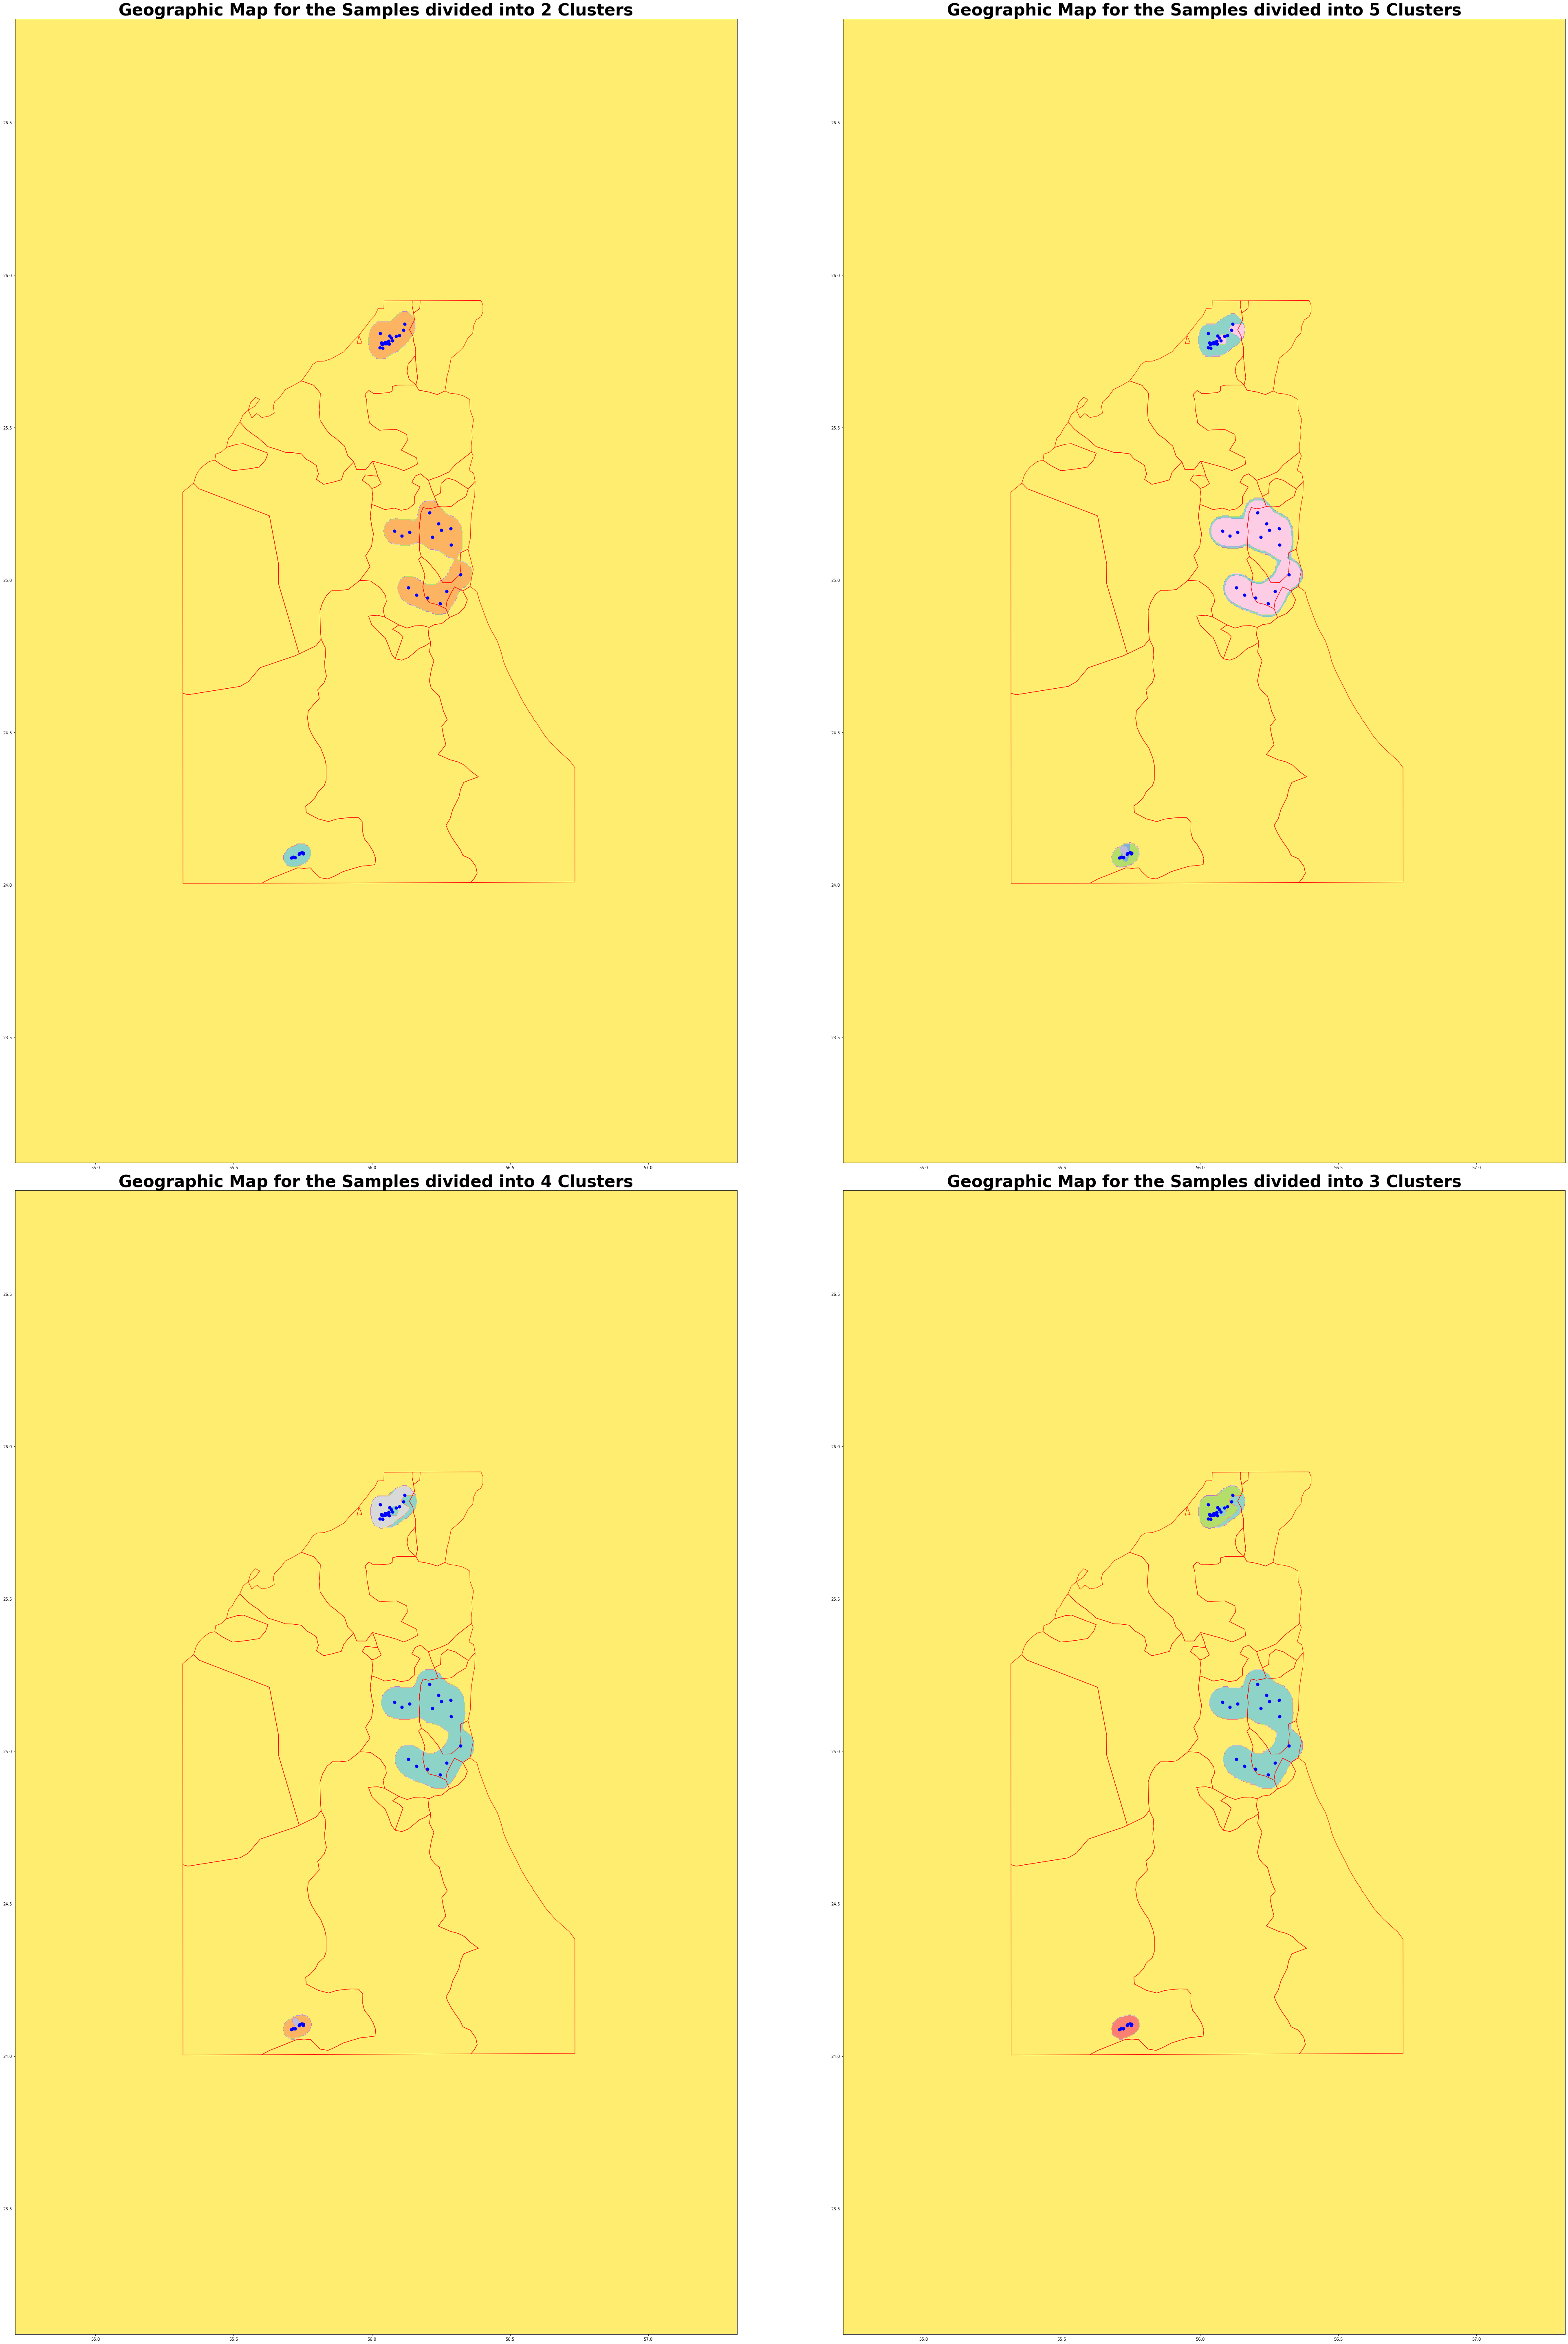

In [175]:
Clusters=topclusts

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(60,80))

#Finding the Most suitable Number of Expected Clusters
for clust in Clusters:
    clf = KMeans(n_clusters=clust)
    clf.fit(data_filled)
    y_pred=list(clf.labels_)
    indx=Clusters.index(clust)

    if indx == 0:
        i=0
        z=0
    elif indx==1:
        i=0
        z=1
    elif indx==2:
        i=1
        z=0
    elif indx==3:
        i=1
        z=1
    
    print('Number of Clusters: ',clust)
    #Clustered
    X=latlong[['LONGITUDE','LATITUDE']]
    print('X: ',len(X))
    y=copy.deepcopy(y_pred)
    print('y: ',len(y))
    X2,y2=bazel_cluster(X,y,  extent=1, random_seed=42)
    print('X2: ',len(X2))
    print('y2: ',len(y2))
    X=X.to_numpy()
    y=np.array(y)
    X2=X2.to_numpy()
    y2=np.array(y2)

    clf = SVC(C= 100, gamma= 700.0, random_state=42)
    clf.fit(X2, y2)
    print('Drawing Accuracy: ',clf.score(X, y), '\n\n')
    # clf.fit(X_train, y_train)
    # print(clf.score(X_test, y_test))
    cmap = mpl.colormaps['Set3']

    axes[i][z].set_title(f'Geographic Map for the Samples divided into {clust} Clusters',fontsize = 40, fontweight ="bold")
    
#     disp = plot_decision_regions(X, y, clf=clf, legend=0, ax=axes[i][z], cluster='ray')
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, response_method='predict', ax=axes[i][z] ,grid_resolution=1000, plot_method='contourf', cmap=cmap)
    shapFileFiltered.plot( color='none', edgecolor='red', ax=axes[i][z])
    gdf.plot( marker='o',  color='blue', markersize=50, ax=axes[i][z])
fig.tight_layout()

In [176]:
# fig.savefig('ClustMap.png')

X:  45
y:  45
X with Bazel:  65
y with Bazel:  65
Drawing Accuracy:  100.0 %




,LONGITUDE,LATITUDE,pH,Temperature (C),TDS,Na+,K+,Cl-,SO42+,222Rn (Bq/L),SRTM_DEM (Elevation m),Class
Sample_Name,,,,,,,,,,,,
SP1,373072,2665980.617,8.07,48.1,6300,1415,52.0,3021.000000,680.00000,35.00,300,1
SP2,372867,2666397.946,7.98,40.9,10060,2200,72.0,4813.000000,1070.00000,23.00,288,1
SP3,373147,2666355.028,8.04,44.6,6590,1570,46.0,3373.000000,670.00000,46.00,292,1
SP4,372579,2666539.936,8.10,34.3,11070,2630,77.0,5586.000000,1020.00000,105.00,282,1
SP5,371687,2666234.203,9.30,27.6,13420,3135,121.0,6323.000000,1850.00000,3.53,258,2
SP6,371614,2665954.685,9.33,28.5,13400,2934,95.0,6499.000000,1120.00000,2.46,261,2
SP7,370128,2664779.649,8.68,33.9,8370,2120,70.0,4602.000000,740.00000,120.00,243,1
SP8,369990,2664765.288,8.54,34.3,8340,1786,68.0,4110.000000,670.00000,138.00,240,1
SP9,368714,2664591.262,8.99,30.7,8700,1900,58.0,4391.000000,620.00000,18.00,234,1


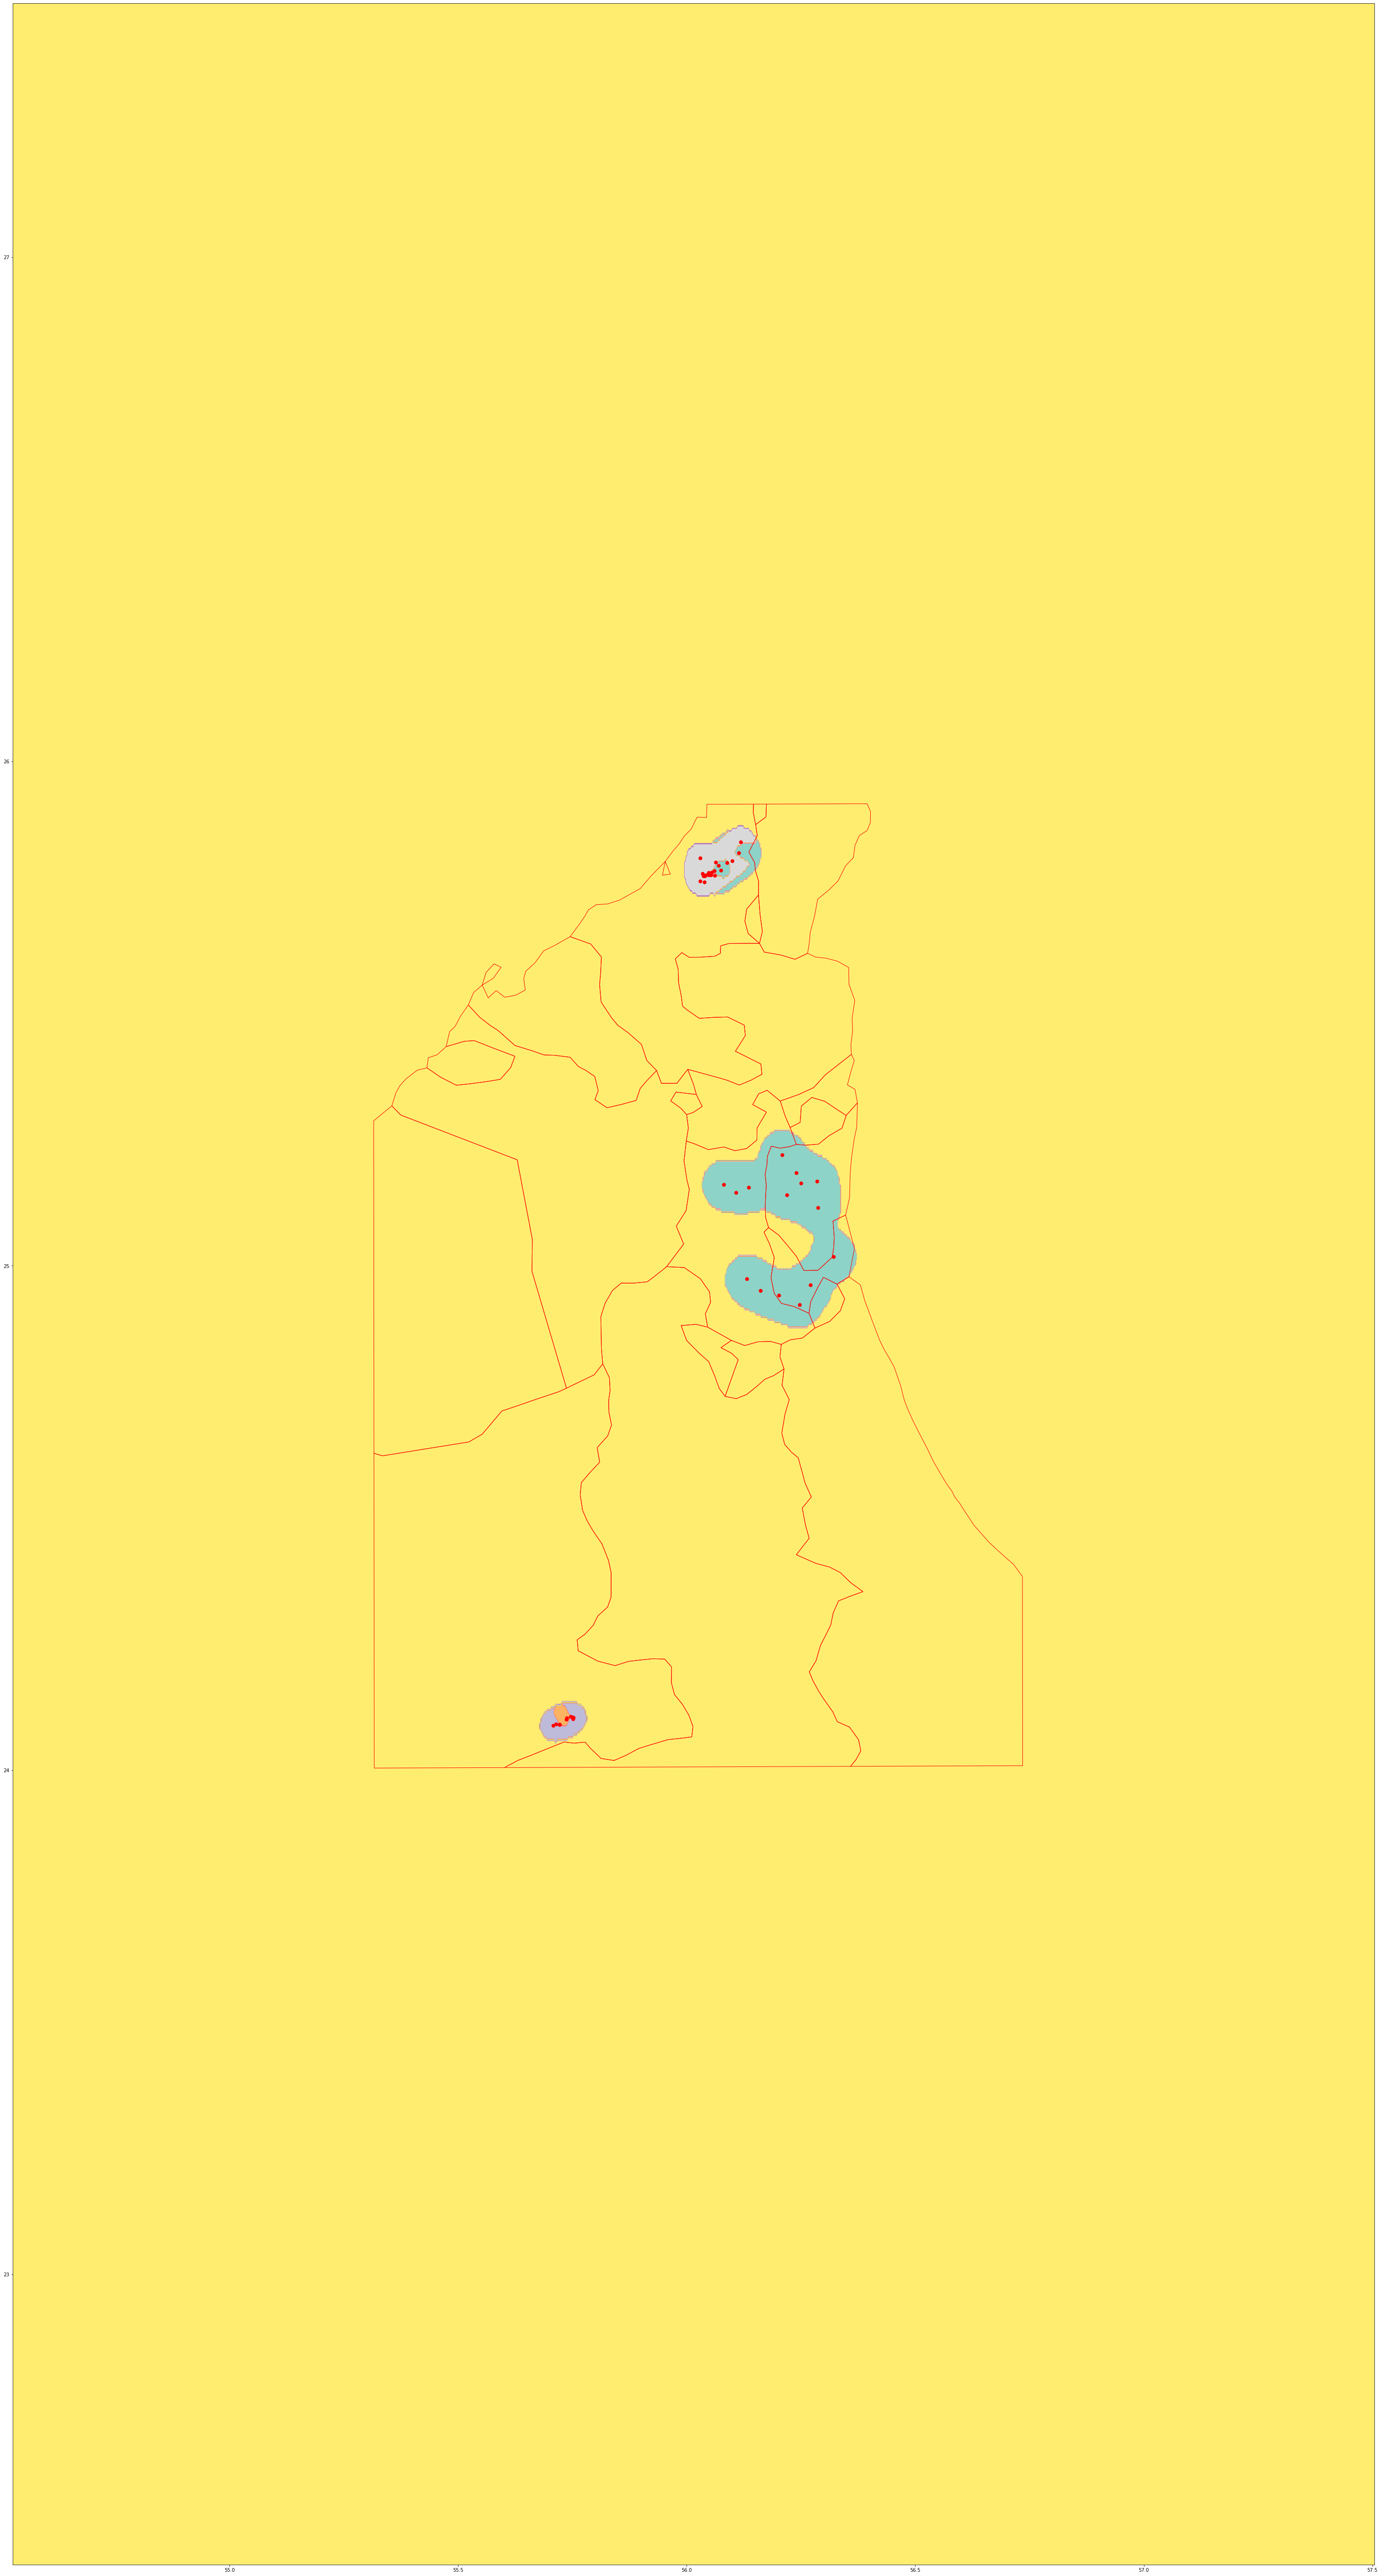

In [192]:
# clf = KMeans(n_clusters=topclusts[0])
clf = KMeans(n_clusters=4)
clf.fit(data_filled)
y_pred=list(clf.labels_)

fig=geoz.sklearn_plot(latlong,y_pred, gamma=700.0, grid_resolution=1000, bazel=True, random_seed=42)
shapFileFiltered.plot(color='none', edgecolor='red',figsize=(10,20), ax=fig)
# geoz.mlx_plot(latlong,y_pred, bazel=True)
# fig.figure.savefig('test2.pdf')

# data.loc['R-KH18',['Cl-','SO42+']]=data_filled.loc['R-KH18',['Cl-','SO42+']]
data.loc['R-KH18',['Cl-','SO42+']]=scaler.inverse_transform([data_fill.loc['R-KH18'].values])[0][[5,6]]
data['Class']=clf.labels_
data.to_csv('ClassifiedData.csv')
data

In [193]:
temp=shapFileFiltered.plot(color='none', edgecolor='red', ax=fig)
temp.figure.savefig('FinalMap.png')

<Figure size 432x288 with 0 Axes>

In [152]:
surrogate_model = shap.KernelExplainer(clf.predict, data_filled)
shap_values = surrogate_model.shap_values(data_filled)

X does not have valid feature names, but KMeans was fitted with feature names


  0%|          | 0/45 [00:00<?, ?it/s]

X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with 

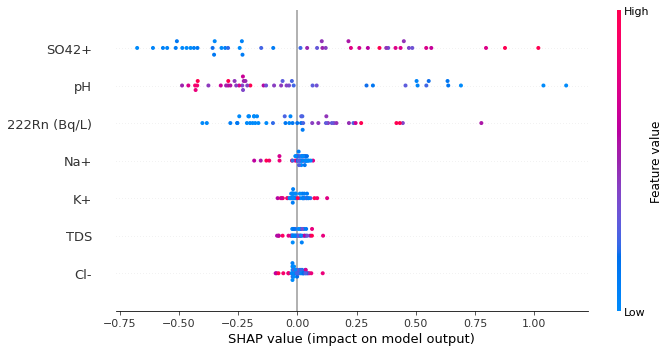

In [153]:
plott=shap.summary_plot(shap_values, data_filled,plot_size=(10,5),show=False)

In [125]:
plt.savefig("summary_plot.png", dpi=300)

<Figure size 432x288 with 0 Axes>

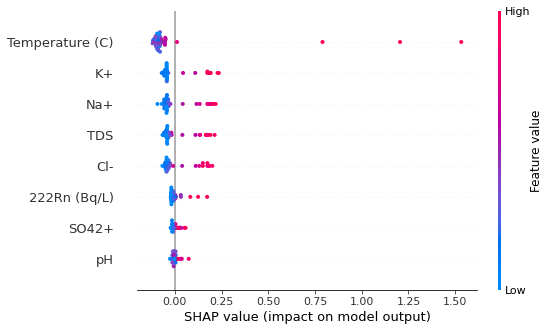

In [37]:
shap.summary_plot(shap_values, data_filled)